In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append("C:/Users/Leon/Documents/AI_project/AI_project")
from Image_processing.Preprocessing.utils import preprocessing as prep

***Show the Image***

In [2]:
import importlib
importlib.reload(prep)

<module 'Image_processing.Preprocessing.utils.preprocessing' from 'C:\\Users/Leon/Documents/AI_project/AI_project\\Image_processing\\Preprocessing\\utils\\preprocessing.py'>

***height (rows), width(cols)***

Load images from storage and pass them through the preprocessing pipeline. The individual steps are:<br>
- Read Image as BGR Format<br>
- Resize Image to square format<br>
- Draw bounding box around the object in the image and convert it to RGB<br>
- get Hight and Width from the bounding box<br>
- check If the box is rotated and depending on that crop the area of the bounding box out of the image<br>
- Do Object Segmentation on the cropped image and return the binary segmented img (mask)<br>
- Get the segmented cropped RGB image<br>
- Place a green mask on the segmented cropped RGB image and get only the green pixels<br>
- Calculate the color from the segmented cropped RGB image with kmeans algorithm. Set k=2<br>
- Write the desired features to the dataframe

In [6]:
folders = ["Kartoffel", "Karotte", "Zwiebel", "Karotte_Trieb", "Zwiebel_Trieb", "Kartoffel_Trieb"]
#folders = ["Internet"]
paths = []
for fold in folders:
    for i, fname in enumerate(os.listdir(f"G:/Meine Ablage/KI_Projekt/Bilder/{fold}"), 1):
        paths.append(f"G:/Meine Ablage/KI_Projekt/Bilder/{fold}/{fname}")
        if i == 25:
            break
paths[25:50]  

['G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_1.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_2.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_3.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_4.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_5.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_6.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_7.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_8.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_9.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_10.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_11.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_12.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_13.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_14.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_15.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_16.jpg',
 'G:/Meine Ablage/KI_Projekt/Bild

In [15]:
demo_img = ['G:/Meine Ablage/KI_Projekt/Bilder/Zwiebel_Trieb/zwiebel_trieb_20.jpg',
            'G:/Meine Ablage/KI_Projekt/Bilder/Zwiebel/zwiebel_2.jpg'] # 209 previous karotte_trieb Trainingsdaten
paths = demo_img

Zwiebel_Trieb_20
   Hight  Width    R   G   B  green pixels  green onion pixels  ratio area  \
0    254    146  105  82  55           108                  45    0.217789   

   circularity  keypoints  mean keypoints          Label             Image  
0     0.053756         41        5.902414  Zwiebel_Trieb  Zwiebel_Trieb_20  
Zwiebel_Trieb_20
[[ -5 233]
 [  1  87]
 [255 100]
 [248 246]]
((124.87889099121094, 167.0478515625), (254.37548828125, 146.78521728515625), 2.8829636573791504)


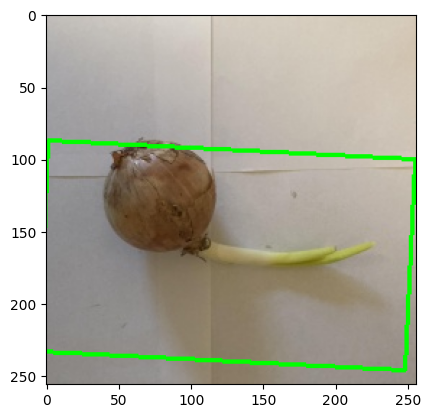

Zwiebel_2
   Hight  Width    R   G   B  green pixels  green onion pixels  ratio area  \
0    254    146  105  82  55           108                  45    0.217789   
1    184    120  118  74  57             0                   0    0.385303   

   circularity  keypoints  mean keypoints          Label             Image  
0     0.053756         41        5.902414  Zwiebel_Trieb  Zwiebel_Trieb_20  
1     0.233313         26        9.245802        Zwiebel         Zwiebel_2  
Zwiebel_2
[[ 12  87]
 [ 93  -2]
 [231 120]
 [150 210]]
((121.90042114257812, 104.00762176513672), (184.786865234375, 121.7731704711914), 41.833675384521484)


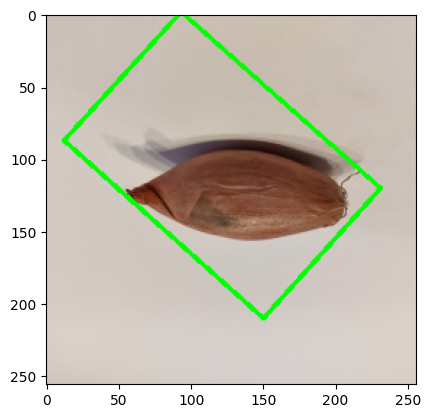

In [24]:
vegis_df = pd.DataFrame(columns=["Hight", "Width", "R", "G", "B", "green pixels",
                                 "green onion pixels", "ratio area", "circularity", 
                                 "keypoints", "mean keypoints", "Label", "Image"])
error_counter = 0
resize_counter = 0
for i, path in enumerate(paths):
    if 'desktop.ini' in path:
        continue

    ############################# Label the image ##################################
    vegi_label = path.split("/")[4]
 
    vegi_BGR = cv2.imread(path) # As BGR
    vegi_sq_BGR_original = prep.resize_to_square(vegi_BGR) # BGR

    #try:
    ############################# Find Contours in image and draw a bounding box ##################################
    vegi_with_box_rgb, more_than_one_box, box, rect, area, circularity = prep.draw_contours(vegi_sq_BGR_original, object_area=500)
    if more_than_one_box:
        box_size = 500
        while more_than_one_box:  # makes sure there is only one bounding box in the image
            box_size += 250
            vegi_with_box_rgb, more_than_one_box, box, rect, area, circularity = prep.draw_contours(vegi_sq_BGR_original, box_size)

    ############################# Get pixel size from the bounding box (hight and width) ##################################
    #FIXME height and width are swapped. Use width and height from rect=(width, height)
    h, w = [int(l) for l in prep.get_size_box(box)]
    
    ############################# Calculate the Ratio Area Feature ##################################
    ratio_area_box = 0
    if h > 0 and w > 0:
        ratio_area_box = area / (h * w)

    ############################# Crop the including area from the bounding box (our ROI) ##################################
    if not prep.is_box_rotated(box):
        #crop img directly
        # the top left corner should be the first element in box array
        cropped_vegi_BGR = vegi_sq_BGR_original[box[0][1]:box[0][1]+h, box[0][0]:box[0][0]+w]
        
    else:
        cropped_vegi_BGR = prep.crop_roi(vegi_sq_BGR_original, box) # BGR

    ############################# Do a binary segmentation only with the roi  ##################################
    cropped_segmented_binary_2 = prep.segment_img_2(cropped_vegi_BGR)
    #print("Segmented BINARY From Cop NEW")
    #show_image_plt(cropped_segmented_binary_2)

    ############################# Apply the binary mask on the cropped image  ##################################
    cropped_vegi_segmented_rgb_2 = prep.color_from_segmented_binary(cropped_segmented_binary_2, cropped_vegi_BGR) # center has rgb format
    #print("Segmented RGB")
    #show_image_plt(cropped_vegi_segmented_rgb_2)

    ##################### SIFT Algorithm - Calculates the mean keypoints and number of keypoints features #######################################
    num_kps, mean_kps = prep.sift(vegi_sq_BGR_original)

    ############################# Apply a green mask on the image ##################################
    # Seems to be work best
    vegi_only_onion_tribe_rgb, onion_tribe_mask = prep.mask_green(cropped_vegi_segmented_rgb_2, lower_thresh=(25, 40, 20), higher_thresh=(60, 160, 255))
    #print("ONLY GREEn TRIBE MASK")
    #show_image_plt(vegi_only_onion_tribe_rgb)
    vegi_only_tribe_rgb, tribe_mask = prep.mask_green(cropped_vegi_segmented_rgb_2, lower_thresh=(27, 105, 20), higher_thresh=(120, 255, 255))
    ############################# Calculates the number of green pixels feature  ##################################
    amount_green_pixels_onion_tribe = prep.count_green_pixels(onion_tribe_mask)
    amount_green_pixels_tribe = prep.count_green_pixels(tribe_mask)
    ############################# Get the Color (R, G, B) Feature(s) with a kmean algorithm ##################################
    center, ret, label = prep.get_color(cropped_vegi_segmented_rgb_2) #Center = RGB
    R, G, B = np.max(center, axis=0)
    
    a = path.split(".")
    b = a[0].split("_")
    img_name = f"{vegi_label}_{b[-1]}"
    vegis_df.loc[len(vegis_df)] = [h, w, R, G, B, amount_green_pixels_tribe, amount_green_pixels_onion_tribe, ratio_area_box, circularity, num_kps, mean_kps, vegi_label, img_name]
    print(img_name)
    if i < 3:
        print(vegis_df)
    new_img, new_box = prep.resize_bound_box_and_draw(vegi_with_box_rgb, rect, box)
    print(img_name)
    print(box)
    print(rect)
    prep.show_image_plt(vegi_with_box_rgb)
    """
    try:
        new_img, new_box = prep.resize_bound_box_and_draw(vegi_with_box_rgb, rect, box)
        #cv2.imwrite(f"G:/Meine Ablage/KI_Projekt/Bilder/Debugging_resize_function/{img_name}_{i}.jpg", new_img)
    except Exception as e:
        resize_counter += 1
        print(e)
    """
    #print(img_name)
    #, cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
        
        
    #except Exception as e:
    #    print(f"########## Error: {e}")
    #    error_counter += 1
    

In [23]:
t = np.array([-5, 254])
if (t < 0).any() and (t > 255).any():
    print("yes")

In [18]:
print(rect)
print(box)

((121.90042114257812, 104.00762176513672), (184.786865234375, 121.7731704711914), 41.833675384521484)
[[ 12  87]
 [ 93  -2]
 [231 120]
 [150 210]]


In [25]:
v_0_3 = box[3] - box[0] # is equal to vector v_1_2
print(v_0_3)
v_prev_point = box[0 - 1] - box[0]
print(v_prev_point)

[138 123]
[138 123]


In [34]:
box[0] = (-5, 87)
print(box)

[[ -5  87]
 [  5  93]
 [231 120]
 [150 210]]


In [35]:
#v_0_1 = box[1] - box[0] # is equal to vector v_2_3
#v_0_3 = box[3] - box[0] # is equal to vector v_1_2
print("old box: ", box)
point_at_idx = 0
debug_counter = 0
while (box < 0).any() or (box > 255).any():
    moved_along_vector_next = False
    moved_along_vector_prev = False
    # if the case exists that 4 iterations are not enough to get a box within the image boundaries
    if point_at_idx == 4:
        point_at_idx = 0 
    
    # get the vectors of the next and previous points in the box
    if point_at_idx < 3:
        next_idx = point_at_idx + 1
        prev_idx = point_at_idx - 1
        v_next_point = box[next_idx] - box[point_at_idx]
        v_prev_point = box[prev_idx] - box[point_at_idx]
        p_next = box[next_idx]
        p_prev = box[prev_idx]
    else:
        # extra case for point_at_idx = 3, to prevent of out of index error
        next_idx = 0
        prev_idx = 2
        v_next_point = box[next_idx] - box[point_at_idx]
        v_prev_point = box[prev_idx] - box[point_at_idx]
        p_next = box[next_idx]
        p_prev = box[prev_idx]

    #TODO always move point along the shorter vector
    #TODO always parallel moving of points
    # check if x cooridnate is left from the image
    if box[point_at_idx][0] < 0:
        # set x to 0 and calculate new y
        temp_p_x_vec_next, temp_p_y_vec_next = prep.move_point_along_vector(box[point_at_idx], 
                                                                            v_next_point, 
                                                                            (0, None))
        temp_p_x_vec_prev, temp_p_y_vec_prev = prep.move_point_along_vector(box[point_at_idx], 
                                                                            v_prev_point, 
                                                                            (0, None))
        # calculate the length from p_old to p_new for prev and next vector
        l_v_next, v_p_old_to_p_new_next = prep.calculate_length_of_moving_vectors(box[point_at_idx],
                                                                                  temp_p_x_vec_next,
                                                                                  temp_p_y_vec_next)
        l_v_prev, v_p_old_to_p_new_prev = prep.calculate_length_of_moving_vectors(box[point_at_idx],
                                                                                  temp_p_x_vec_prev,
                                                                                  temp_p_y_vec_prev)
        
        # move p_old along the shorter vector - finally get p_new
        if l_v_next < l_v_prev:
            new_p_x, new_p_y = temp_p_x_vec_next, temp_p_y_vec_next
            moved_along_vector_next = True
            print("Next")
        else:
            new_p_x, new_p_y = temp_p_x_vec_prev, temp_p_y_vec_prev
            moved_along_vector_prev = True
            print("Prev")

        # check wich point to move parallel
        # if moving along vector_prev then move the point_at_next_index
        # if moving along vector_next then move the point_at_prev_index
            if moved_along_vector_next:
                new_p_prev_x, new_p_prev_y = prep.parallel_shift_neighbour_point(p_prev, v_p_old_to_p_new_prev)
            elif moved_along_vector_prev:
                new_p_next_x, new_p_next_y = prep.parallel_shift_neighbour_point(p_next, v_p_old_to_p_new_next)

        #TODO necessary to save in which direction i moved the point to ensure to resize the box in equal ratio
                


        # check which vector to use to move the points. It is possible two points are left from the image
        # depending on angle from rect. rect < 45:   
        # just use the point_at_idx ???
    
    #TODO For the next case I can use the same code from above change the border param, respectively
    # check if y coordinate of point is above the image
    elif box[point_at_idx][1] < 0:
        # set y to 0 and calculate new x
        pass
    # check if x coordinate is right from the image
    elif box[point_at_idx][0] > 255:
        # set x to 255 and calculate new y
        pass
    # check if y coordinate of point is below the image
    elif box[point_at_idx][1] > 255:
        # set y to 255 and calculate new x
        pass

    #TODO Last Step reasign the box with the current new calculated points
    print("prev_idx", prev_idx)
    print("next_idx", next_idx)
    box[point_at_idx] = (new_p_x, new_p_y)
    if moved_along_vector_next:
        box[prev_idx] = (new_p_prev_x, new_p_prev_y)
    elif moved_along_vector_prev:
        box[next_idx] = (new_p_next_x, new_p_next_y)


    point_at_idx += 1
    debug_counter += 1
    if debug_counter == 10:
        break

print("new box: ", box)

old box:  [[ -5  87]
 [  5  93]
 [231 120]
 [150 210]]
Prev
prev_idx -1
next_idx 1
new box:  [[  0  90]
 [ 10  96]
 [231 120]
 [150 210]]


The resized image to 256x256 pixels


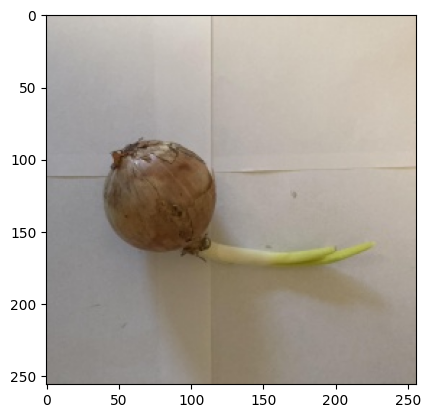

Shows the bounding box which was drawed around the founded contours


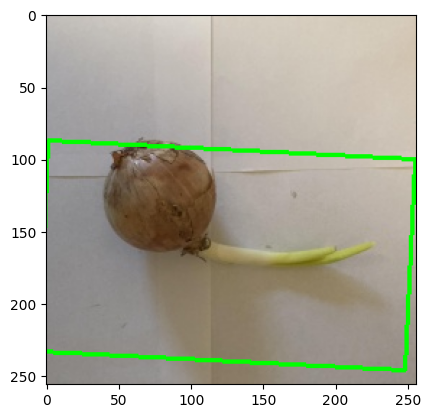

Segmented Binary Image 


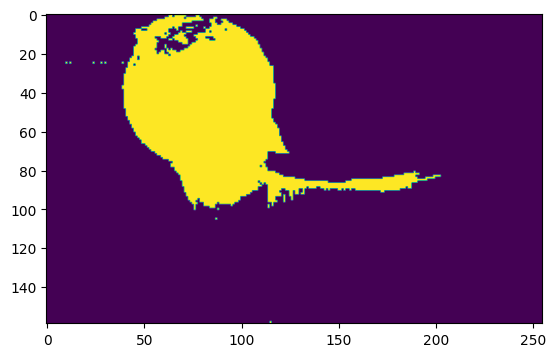

Segmented Image after applying the binary mask


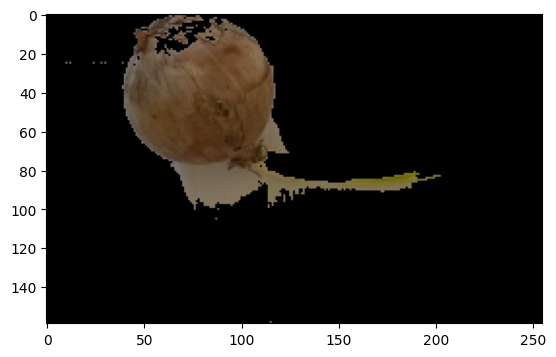

Shows the green color mask to get only the green pixels from the image


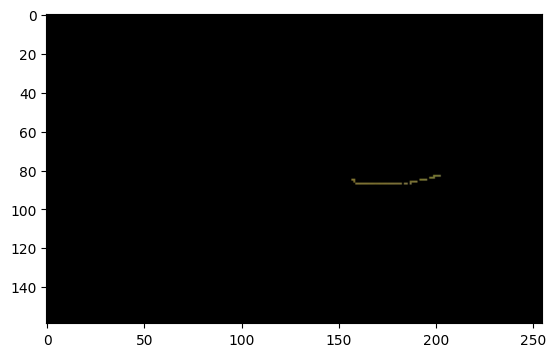

In [8]:
print("The resized image to 256x256 pixels")
prep.show_image_plt(cv2.cvtColor(vegi_sq_BGR_original, cv2.COLOR_BGR2RGB))

print("Shows the bounding box which was drawed around the founded contours")
prep.show_image_plt(vegi_with_box_rgb)

print("Segmented Binary Image ")
prep.show_image_plt(cropped_segmented_binary_2)

print("Segmented Image after applying the binary mask")
prep.show_image_plt(cropped_vegi_segmented_rgb_2)

print("Shows the green color mask to get only the green pixels from the image")
prep.show_image_plt(vegi_only_onion_tribe_rgb)

In [ ]:
#vegis_df.to_csv("G:/Meine Ablage/KI_Projekt/Daten/.csv")

In [12]:
rect

((124.87889099121094, 167.0478515625),
 (254.37548828125, 146.78521728515625),
 2.8829636573791504)

In [10]:
box

array([[ -5, 233],
       [  1,  87],
       [255, 100],
       [248, 246]], dtype=int64)

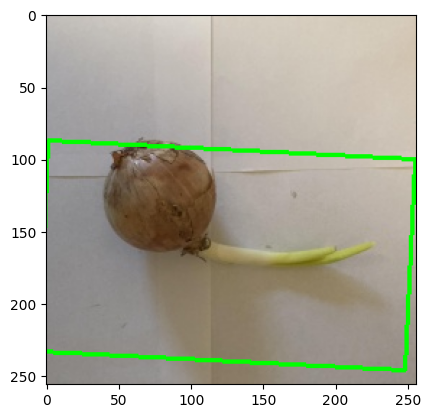

In [9]:
prep.show_image_plt(vegi_with_box_rgb)

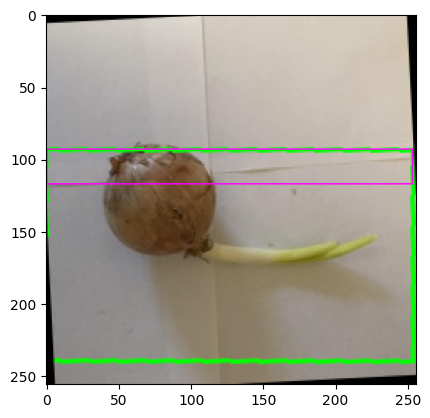

In [11]:
prep.show_image_plt(new_img)

Outside count:  2
This is case 2
point_idx_1:  0 point_idx_2:  1
eps:  0.10071942446043165
vector x:  139
vector y:  219
New Point x= 0 y= 31
New Point x= 110 y= 0
Length l_0= 26.076809620810597 and l_1= 58.83026432033091
[(10, 184), (10, 74), (210, 72), (210, 184)]


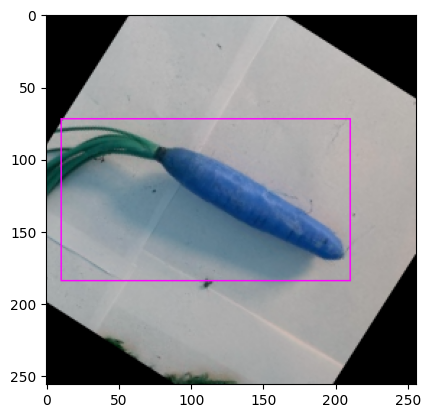

[(10, 184), (10, 72), (210, 72), (210, 184)]


In [64]:
new_img, new_box = prep.resize_bound_box_and_draw(vegi_sq_BGR_original, rect, box)
prep.show_image_plt(new_img)
print(new_box)

In [1]:
def f(p):
    return [p+1, p+2, p+5, p+6]



In [3]:
l = []
l = f(1)
print("first list", l)
l = []
l = f(2)
print("second list", l)

first list [2, 3, 6, 7]
second list [3, 4, 7, 8]
